In [58]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier #untuk membangun model

from sklearn.model_selection import train_test_split #split data

warnings.filterwarnings('ignore') # To supress warnings

In [59]:
df = pd.read_csv('/content/bank-full.csv')

In [60]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [61]:
df.rename(columns={'default': 'credit', 'Target': 'subs_depo'}, inplace=True)

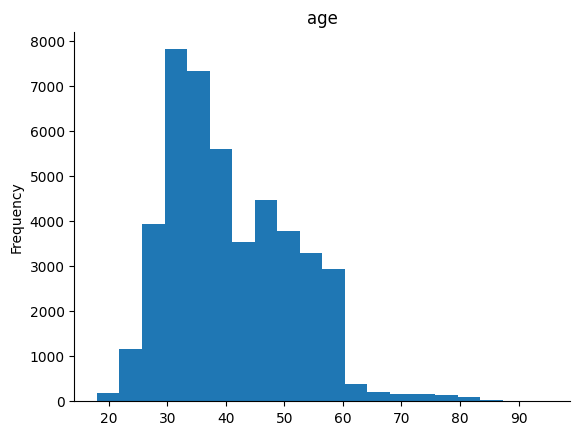

In [62]:
from matplotlib import pyplot as plt
df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

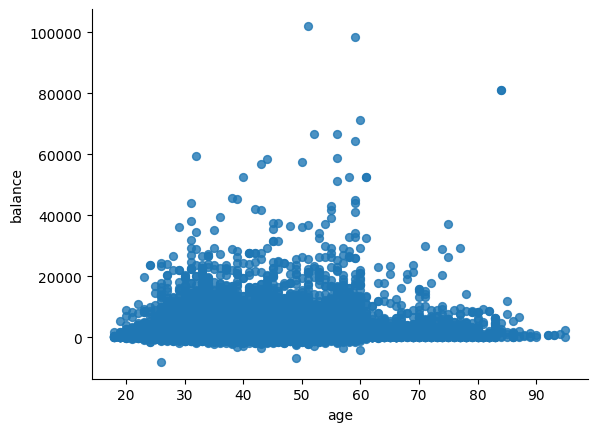

In [63]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='age', y='balance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   credit     45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  subs_depo  45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [65]:
#memilih categorical feature
categorical=[]
for col, value in df.items():
  if value.dtype == 'object':
    categorical.append(col)

#store numerical kolum list
df2 = df[categorical]

In [66]:
df2.head()

,job,marital,education,credit,housing,loan,contact,month,poutcome,subs_depo
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


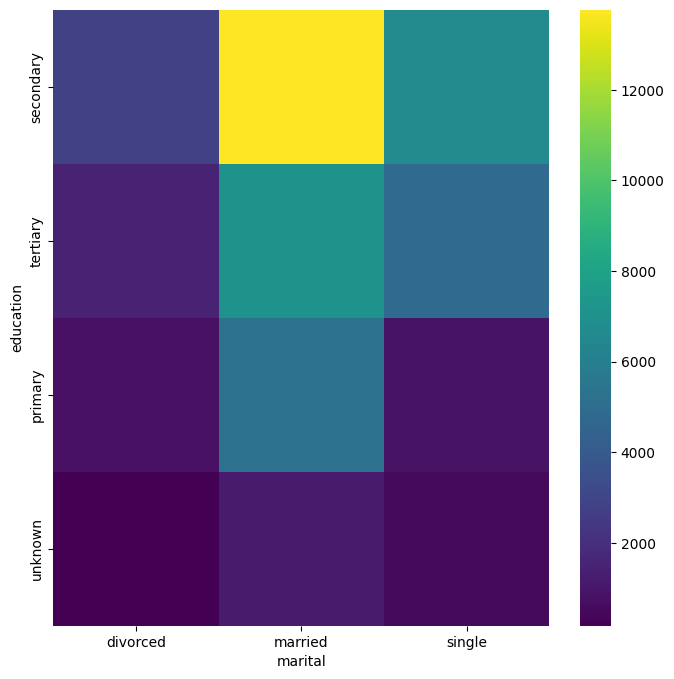

In [67]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in df2.groupby('marital')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('marital')
_ = plt.ylabel('education')

In [68]:
#convert to numerical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df2_feature_select = df2.copy()

for columnName in df2_feature_select:
  df2_feature_select[columnName] = le.fit_transform(df2_feature_select[columnName])

df2_feature_select.head()

,job,marital,education,credit,housing,loan,contact,month,poutcome,subs_depo
0,4,1,2,0,1,0,2,8,3,0
1,9,2,1,0,1,0,2,8,3,0
2,2,1,1,0,1,1,2,8,3,0
3,1,1,3,0,1,0,2,8,3,0
4,11,2,3,0,0,0,2,8,3,0


In [69]:
# Membuat korelasi antara fitur dan target
cor = df2_feature_select.corr()
cor_target = abs(cor['loan'])
relevant_features = cor_target[cor_target > 0.03]
relevant_features

job          0.033004
marital      0.046893
education    0.048574
credit       0.077234
housing      0.041323
loan         1.000000
subs_depo    0.068185
Name: loan, dtype: float64

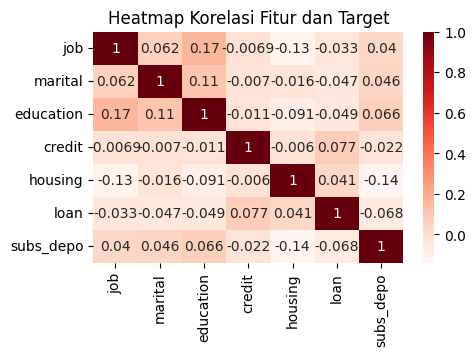

In [70]:
# Memilih fitur yang relevan
relevant_df = df2_feature_select[relevant_features.index]

# Membuat heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(relevant_df.corr(), annot=True, cmap=plt.cm.Reds)
plt.title('Heatmap Korelasi Fitur dan Target')
plt.show()

In [71]:
relevant_features_col = ['job','marital','education','credit','housing', 'subs_depo','loan']
selected_df= df2[relevant_features_col]

In [72]:
#meghapus kolom yang tidak digunakan di model
df3 = df2_feature_select.drop(columns=["contact", "month","poutcome"])

In [73]:
X_dt = df3.drop('loan', axis=1)
y_dt = df3['loan']

In [74]:
oneHotCols=X_dt.select_dtypes(exclude='number').columns.to_list()
X_dt=pd.get_dummies(X_dt,columns=oneHotCols,drop_first=True)
# Spliting data set
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.3, random_state=1, stratify=y_dt)

In [75]:
##  Function to calculate recall score
def get_recall_score(model):
    '''
    model : classifier to predict values of X

    '''
    ytrain_predict = model.predict(X_train_dt)
    ytest_predict = model.predict(X_test_dt)
    # accuracy on training set
    print("\x1b[0;30;47m \033[1mAccuracy : Train :\033[0m",
          model.score(X_train_dt,y_train_dt),
          "\x1b[0;30;47m \033[1mTest:\033[0m",
          model.score(X_test_dt,y_test_dt))
# accuracy on training set
    print("\x1b[0;30;47m \033[1mRecall   : Train :\033[0m",
          metrics.recall_score(y_train_dt,ytrain_predict),
          "\x1b[0;30;47m \033[1mTest:\033[0m",
          metrics.recall_score(y_test_dt,ytest_predict))

In [76]:
#since data is imbalanced adding weights
model = DecisionTreeClassifier(criterion = 'gini',class_weight={0:0.15,1:0.85}, random_state=1)
model.fit(X_train_dt, y_train_dt)
get_recall_score(model)

 Accuracy : Train : 0.5147407337188359  Test: 0.5024329106458272
 Recall   : Train : 0.7426543088148294  Test: 0.6925908881730327


In [77]:
column_names = list(X_dt.columns)
feature_names = column_names
print(feature_names)

['job', 'marital', 'education', 'credit', 'housing', 'subs_depo']


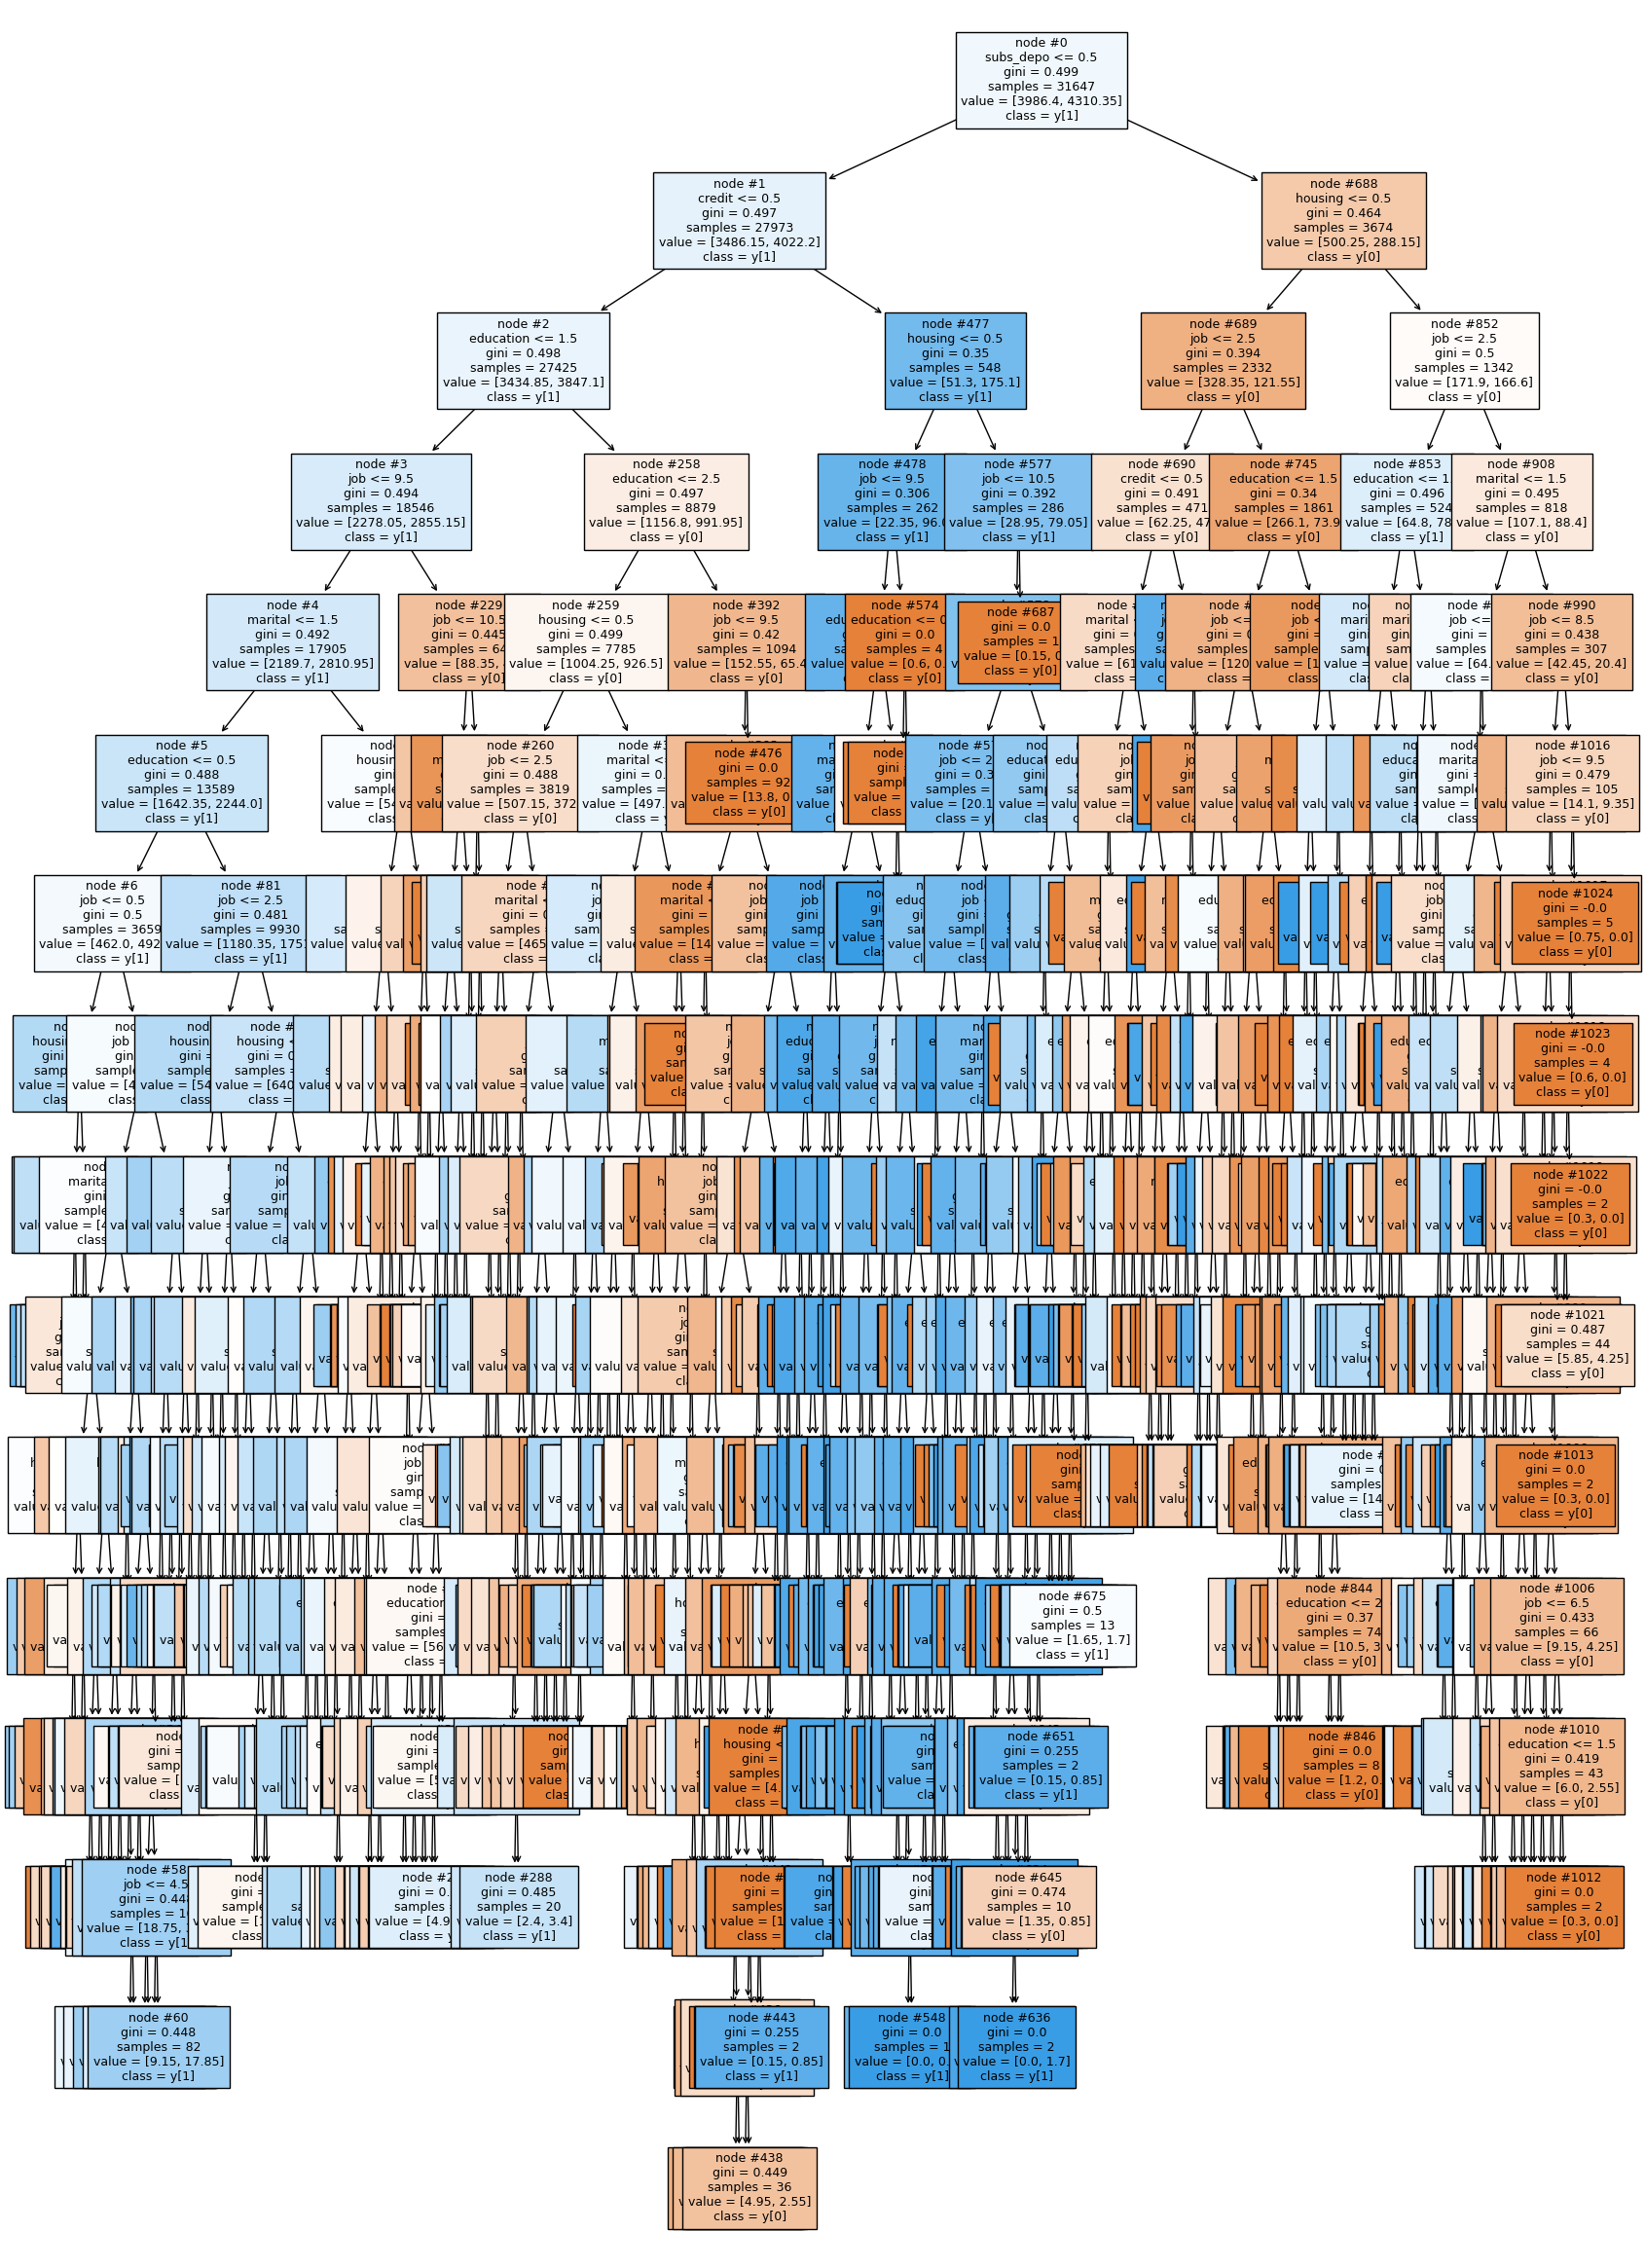

In [78]:
plt.figure(figsize=(20,30))

out = tree.plot_tree(model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [79]:
# report decision tree -

print(tree.export_text(model,feature_names=feature_names,show_weights=True))

|--- subs_depo <= 0.50
|   |--- credit <= 0.50
|   |   |--- education <= 1.50
|   |   |   |--- job <= 9.50
|   |   |   |   |--- marital <= 1.50
|   |   |   |   |   |--- education <= 0.50
|   |   |   |   |   |   |--- job <= 0.50
|   |   |   |   |   |   |   |--- housing <= 0.50
|   |   |   |   |   |   |   |   |--- marital <= 0.50
|   |   |   |   |   |   |   |   |   |--- weights: [0.45, 1.70] class: 1
|   |   |   |   |   |   |   |   |--- marital >  0.50
|   |   |   |   |   |   |   |   |   |--- weights: [3.90, 6.80] class: 1
|   |   |   |   |   |   |   |--- housing >  0.50
|   |   |   |   |   |   |   |   |--- marital <= 0.50
|   |   |   |   |   |   |   |   |   |--- weights: [1.65, 2.55] class: 1
|   |   |   |   |   |   |   |   |--- marital >  0.50
|   |   |   |   |   |   |   |   |   |--- weights: [8.70, 12.75] class: 1
|   |   |   |   |   |   |--- job >  0.50
|   |   |   |   |   |   |   |--- job <= 6.50
|   |   |   |   |   |   |   |   |--- marital <= 0.50
|   |   |   |   |   |   |   |   | 

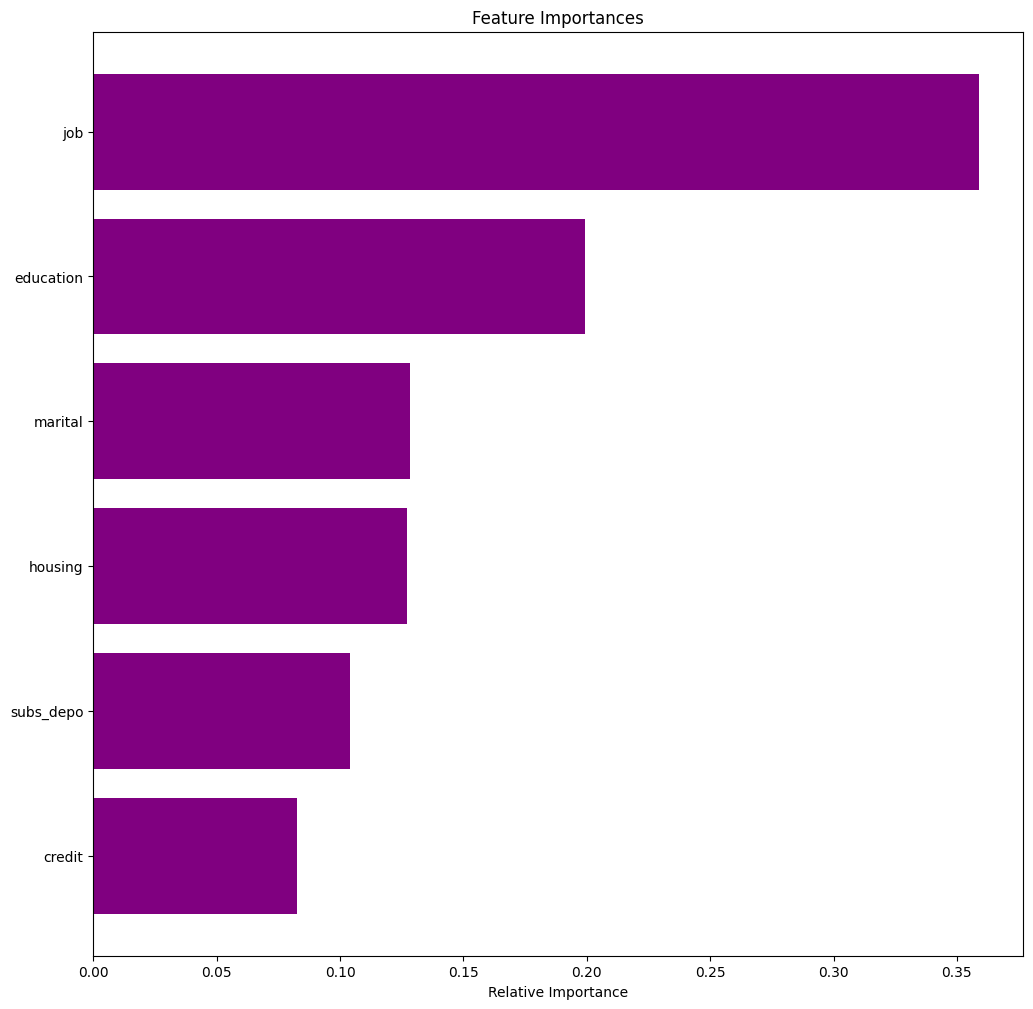

In [80]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Grid Search

In [97]:
#Memilih tipe classifier
estimator = DecisionTreeClassifier(random_state=1)

# Grid search parameter

parameters = {'max_depth': np.arange(1,10),
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              }

# Jenis penilaian yang digunakan untuk membandingkan kombinasi parameter
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Jalankan grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train_dt, y_train_dt)

# Atur clf ke kombinasi parameter terbaik
estimator = grid_obj.best_estimator_
estimator

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=30, min_samples_leaf=10,
                       random_state=1)

In [98]:
# Sesuaikan algoritma terbaik dengan data.
estimator.fit(X_train_dt, y_train_dt)
ytrain_predict=estimator.predict(X_train_dt)
ytest_predict=estimator.predict(X_test_dt)

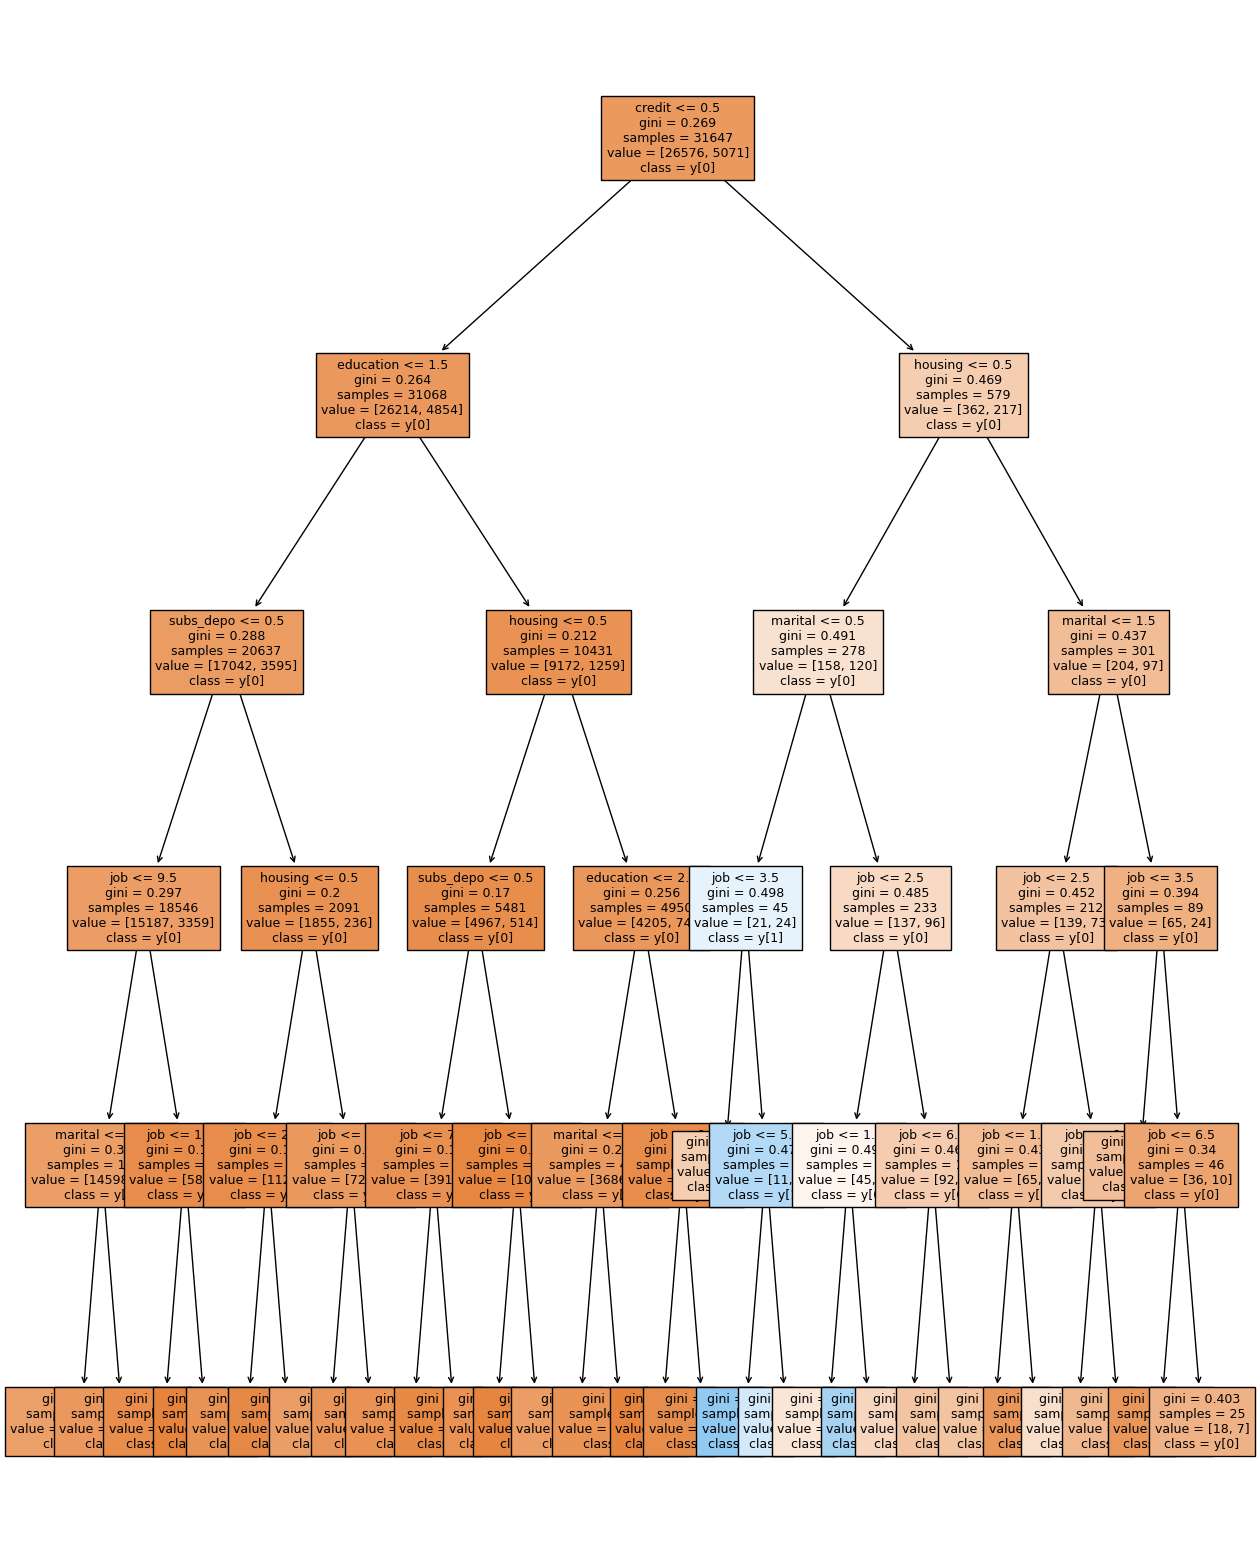

In [99]:
plt.figure(figsize=(15,20))

out = tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

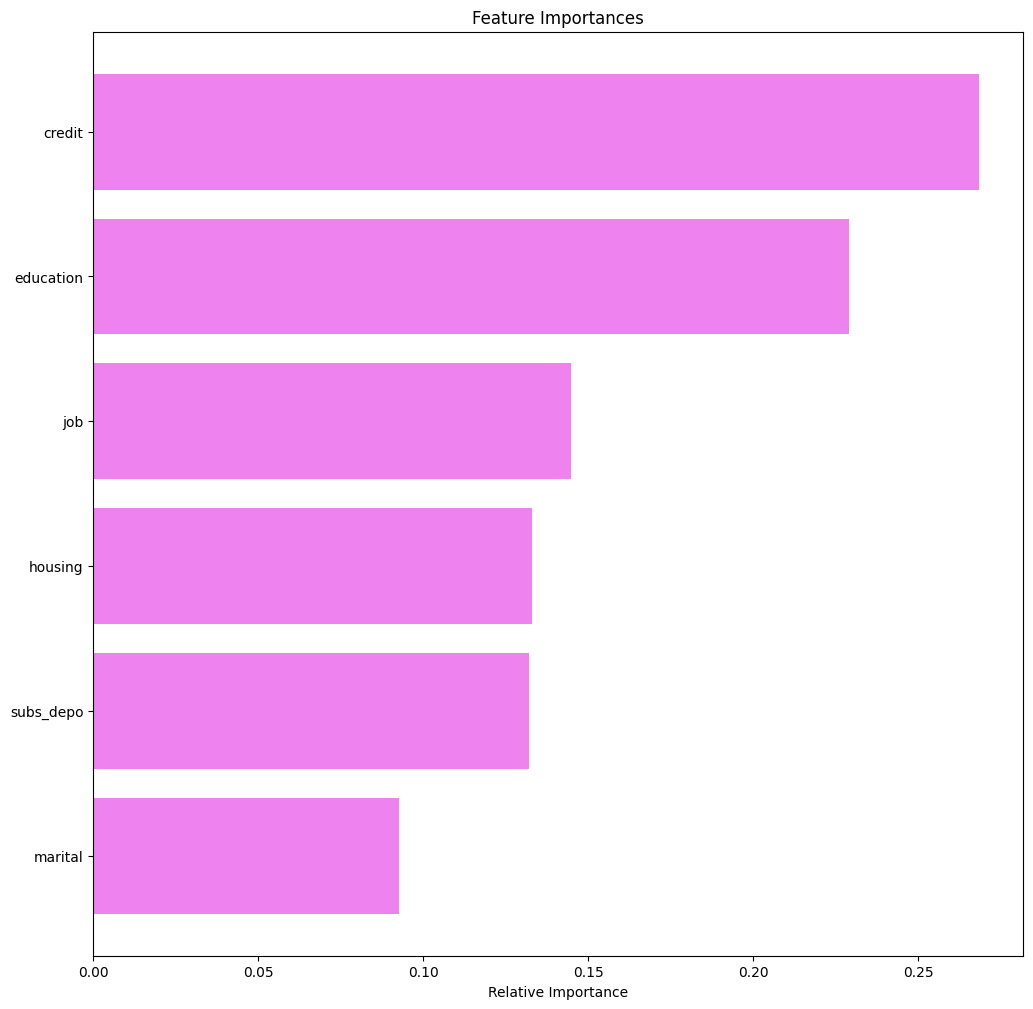

In [100]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [101]:
get_recall_score(estimator)

 Accuracy : Train : 0.8401112269725408  Test: 0.8396490710704807
 Recall   : Train : 0.005324393610727667  Test: 0.004601932811780948


In [102]:
y_pred = estimator.predict(X_test_dt)
print(classification_report(y_test_dt,y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     11391
           1       0.45      0.00      0.01      2173

    accuracy                           0.84     13564
   macro avg       0.65      0.50      0.46     13564
weighted avg       0.78      0.84      0.77     13564



In [103]:
misclass_df = X_test_dt.copy()

In [104]:
misclass_df['Actual']=y_test_dt
misclass_df['Predicted'] = y_pred

([<matplotlib.patches.Wedge at 0x79e34d65e110>,
 [Text(-0.9635984318417689, 0.5305450613775271, ''),
  Text(0.9635984815149782, -0.5305449711589287, '')],
 [Text(-0.5255991446409648, 0.28938821529683295, '84.0%'),
  Text(0.5255991717354426, -0.2893881660866883, '16.0%')])

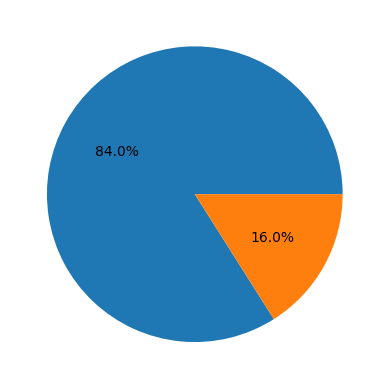

In [105]:
plt.pie(data=misclass_df,x=misclass_df["Actual"].value_counts(),autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x79e34d695840>,
 [Text(-1.0999857195258342, 0.005605072634031831, ''),
  Text(1.0999857191527427, -0.005605145852131296, '')],
 [Text(-0.599992210650455, 0.003057312345835544, '99.8%'),
  Text(0.5999922104469505, -0.0030573522829807063, '0.2%')])

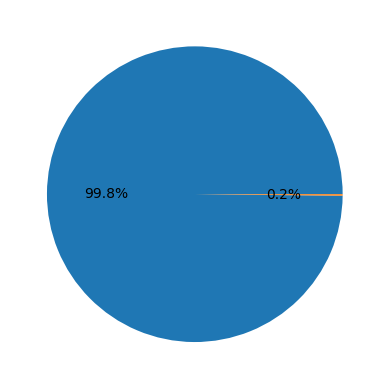

In [106]:
plt.pie(data=misclass_df,x=misclass_df["Predicted"].value_counts(),autopct='%1.1f%%')

In [107]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [108]:
pred = pd.DataFrame(y_pred)

In [109]:
#prediction row
print('Row :\n', selected_df.loc[50])
print('\nActual : ', df3['loan'].loc[50])
print('Prediction : ', pred.loc[50])

Row :
 job          blue-collar
marital          married
education      secondary
credit                no
housing              yes
subs_depo             no
loan                  no
Name: 50, dtype: object

Actual :  0
Prediction :  0    0
Name: 50, dtype: int64


In [110]:
def predict_one(job, marital, education, credit, housing, subs_depo):
  print('Prediction : ', estimator.predict([[job, marital, education, credit, housing, subs_depo]]))

In [111]:
print('Row :\n', df3.loc[50])

Row :
 job          1
marital      1
education    1
credit       0
housing      1
loan         0
subs_depo    0
Name: 50, dtype: int64


In [112]:
print('\nActual : ', df3['loan'].loc[50])
predict_one(1, 1, 1, 0, 1, 0)


Actual :  0
Prediction :  [0]
